In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import astropy.units as u
import sys 
import os
sys.path.append("../src")
from regression import FrequentistRegression
import getpass

username = getpass.getuser()
# from scipy.optimize import curve_fit
params = {
         'axes.labelsize': 25,
         'axes.titlesize': 25,
         'ytick.labelsize' :25,
         'xtick.labelsize' :25,
         'legend.fontsize': 20,
         'xtick.major.size': 5,
         'xtick.minor.size': 4,
         'xtick.major.width': 3,
         'xtick.minor.width': 2,
         'ytick.major.size': 5,
         'ytick.minor.size': 4,
         'ytick.major.width': 3,
         'ytick.minor.width': 2,
         'ytick.color': "k",
         'xtick.color': "k",
         'axes.labelcolor': "k",
         'ytick.labelcolor' : "k",
         'xtick.labelcolor' : "k",
         'font.size': 20
         }
plt.rcParams.update(params)
plt.style.use('science')


# Folder directory for the data and figures of this notebook
data_folder = f'C:/Users/{username}/Desktop/lab_optique/data/faraday/data/' # à changer selon la personne 
figure_folder = f'C:/Users/{username}/Desktop/lab_optique/data/faraday/figures/' # à changer selon la personne 

OSError: 'science' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

### Semaine 1
On explore 2 parties principales cette semaine: 
- 1) Caractérisation du champ magnétique à l'intérieur de la bobine
- 2) Mesure de la constante de Verdet en courant continu avec 3 méthodes différentes

#### Caractérisation du champ magnétique à l'intérieur de la bobine
On a deux sous-parties par cette section.
1) Caractérisation de la variation spatiale du champ magnétique dans la bobine (comment le champ varie si on se déplace à l'intérieur de la bobine)
2) Caractérisation de la variation avec le courant du champ magnétique dans la bobine

In [2]:
def preprocess_B(raw_B, range = 30): 
    """
    Calcul la valeur de B en Gauss étant donné 
    """
    return raw_B * range * u.gauss.to(u.tesla)

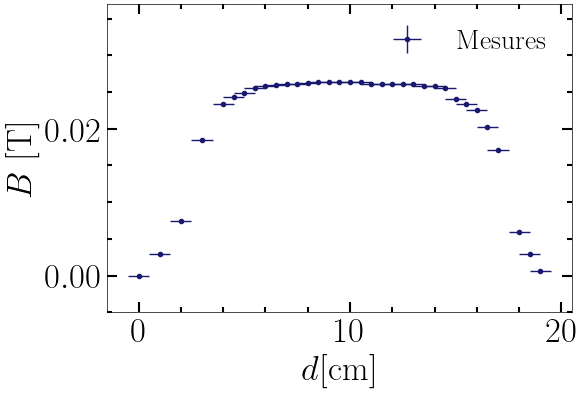

In [173]:
# Importer les données
data = np.loadtxt(data_folder + "d_vs_B.txt", skiprows=1)
D = data[:, 0] # cm 
B = preprocess_B(data[:, 1], range = 30) # Tesla

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
# Importer les incertitudes
std_data = np.loadtxt(data_folder + "incertitude.txt", skiprows=1)
std_B = preprocess_B(std_data[:, 1], range = 30).std(ddof = 1)# Tesla
std_Ib = std_data[:, 0].std(ddof = 1) # icnertitude courant bobine (A)
std_D = 0.5 # cm

ax.errorbar(D, B, xerr = 0.5, yerr = std_B, fmt = ".", label = "Mesures",
             color = "midnightblue")
ax.set_xlabel(r"$d$[cm]")
ax.set_ylabel(r"$B$ [T]")
# plt.xlim([0, 23])
ax.set_ylim([B.min()-0.005, B.max() * 1.4])
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.legend(loc = "upper right")
plt.savefig(figure_folder + "b_vs_distance.pdf", bbox_inches = "tight")

In [161]:
std_Ib

np.float64(0.0024156160934865217)

On note une région où le champ magnétique est presque constant vers le centre de la bobine ! Analysons maintenant comment ceci varie lorsqu'on varie l'intensité du courant à la place de la distance de la sonde dans la bobine. 

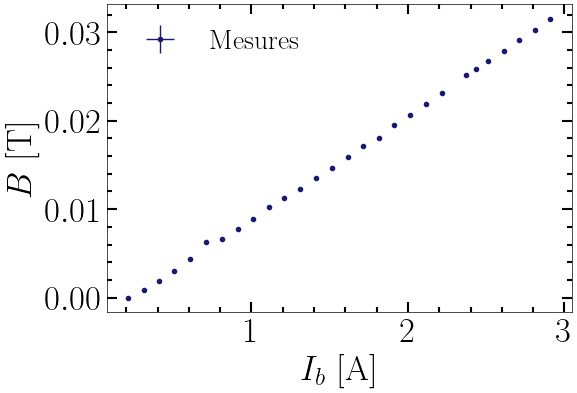

In [162]:
# Importer les données (d = 9 cm, i.e. au milieu de la bobine)
data = np.loadtxt(data_folder + "Ib_vs_B.txt", skiprows=1)
Ib = data[:, 0] # courant dans la bobine (A) 
B = preprocess_B(data[:, 1], range = 30) # Tesla

# incertitudes déjà importées cellule précédente.


fig, ax = plt.subplots(1, 1, figsize = (6, 4))

ax.errorbar(Ib, B, 
            fmt = ".", 
            xerr = std_Ib, 
            yerr = std_B, 
            color = "midnightblue",
            label = "Mesures")
ax.set(xlabel = r"$I_b$ [A]", ylabel = r"$B$ [T]")
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.legend()

On a une relation qui semble linéaire. Faisons un ajustement sur celle-ci afin de pouvoir obtenir le champ magnétique $B$ pour n'importe quel courant $I_b$. Cela revient à trouver les paramètres $\beta_0$ et $\beta_1$ pour la relation suivante
$$
B = \beta_0 I_b + \beta_1  
$$

In [163]:
def linear(x, params_fitted):
    a, b = params_fitted
    return a + b * x

x = Ib
y = B
sigma_y = std_B

Regression_bobine= FrequentistRegression(
    degree = 1,
    sigma_noise = 2 * sigma_y
)

params_fitted, std_fitted = Regression_bobine.fit(
    obs = y, 
    x = x,
    ridge_reg = 1e-12,
    fit_intercept = True
)
B0 = params_fitted[0]
y_pred = Regression_bobine.forward_model()
cov = Regression_bobine.cov
chi2 = Regression_bobine.compute_chi2(obs = y)

print("The parameters fitted are", params_fitted)
print("The std of the params fitted are", std_fitted)
print("The cov of the params fitted is", cov)
print("The chi squared is:", chi2)


The parameters fitted are [-0.00285108  0.01172972]
The std of the params fitted are [5.92922420e-05 3.36224004e-05]
The cov of the params fitted is [[ 3.51556996e-09 -1.76998364e-09]
 [-1.76998364e-09  1.13046581e-09]]
The chi squared is: 2.5382542559590764


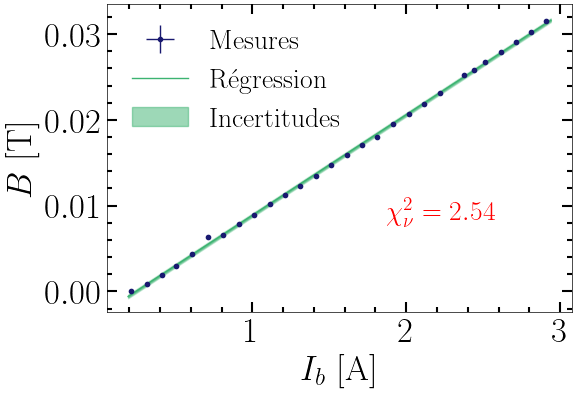

In [167]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

I_fit = np.linspace(0.9 * Ib.min(), 1.01 * Ib.max(), 500)
y_pred_fit = linear(I_fit, params_fitted=params_fitted)
ax.errorbar(Ib, B, 
            fmt = ".", 
            xerr = std_Ib, 
            yerr = std_B, 
            color = "midnightblue",
            label = "Mesures")
ax.errorbar(Ib, B, 
            fmt = ".", 
            xerr = 3 * std_Ib, 
            yerr = 3 * std_B, 
            color = "midnightblue",
            alpha = 0.3)
ax.plot(I_fit, y_pred_fit, label = "Régression", color = "mediumseagreen")

# k = 1
k = 1 
ax.fill_between(
    I_fit, 
    y_pred_fit - k * std_B,
    y_pred_fit + k * std_B,
    label = "Incertitudes", 
    color = "mediumseagreen", 
    alpha = 0.5
)

k = 3
ax.fill_between(
    I_fit, 
    y_pred_fit - k * std_B,
    y_pred_fit + k * std_B,
    color = "mediumseagreen", 
    alpha = 0.3
)
ax.set(xlabel = r"$I_b$ [A]", ylabel = r"$B$ [T]")
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2, xy = (0.6, 0.3), xycoords = "axes fraction", color = "red", fontsize = 20)
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.legend(loc = "upper left", handles = [handles[idx] for idx in order], labels = [labels[idx] for idx in order])
plt.savefig(figure_folder + "b_vs_current.pdf", bbox_inches = "tight")

In [159]:
Ib

array([0.10543, 0.2139 , 0.4143 , 0.6086 , 0.81406, 1.01223, 1.4124 ,
       1.8119 , 2.2148 , 2.416  , 2.8135 , 2.948  ])

Parfait. Créons une fonction pour aller de $I_b$ (A) à $B$ (Tesla)

In [7]:
def Ib_to_B(x, params_reg = params_fitted): 
    """
    Ib (amperes) à B (Tesla)
    """
    a, b = params_reg
    return a + b * x

#### Mesure de la constante de Verdet
La relation qu'on utilisera est la suivante 
$$
\theta = VBL \rightarrow V = \frac{BL}{\theta}
$$
où $V$ est la constante de Verdet, $L=10^{-2}$ m  et $B$ est le champ magnétique au sein de la bobine (calculable par le travail qu'on a fait ci-dessus). 

##### Méthode 1: Par extension (ajustement de l'angle des deux polariseurs)

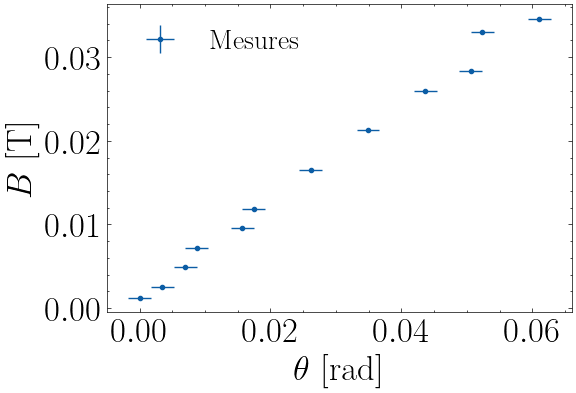

In [89]:
# Importer les données (d = 9 cm, i.e. au milieu de la bobine)
data = np.loadtxt(data_folder + "method_extension.txt", skiprows=1)
theta0 = 168 * u.degree.to(u.radian)
angle_1 = data[:, 0] * u.degree.to(u.radian) - theta0  # radians
std_angle_extension = 0.1 * u.degree.to(u.radian)
L = 10 * 1e-2 # meters
Ib = data[:, 1]  # courant dans la bobine (A)
B_1 = Ib_to_B(Ib)

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.errorbar(angle_1, B_1-B0, fmt = ".", label = "Mesures", xerr = std_angle_extension, yerr = std_B)
ax.set(xlabel = r"$\theta$ [rad]", ylabel = r"$B$ [T]")
ax.legend()

In [90]:
def linear_2(x, params_fitted):
    return params_fitted * x

x = B_1-B0
y = angle_1 # on échange puisque l'incertitude due à l'angle est plus importante ici
sigma_y = std_angle_extension

Regression_extension= FrequentistRegression(
    degree = 1,
    sigma_noise = sigma_y
)

param_fitted_1, std_fitted = Regression_extension.fit(
    obs = y, 
    x = x,
    ridge_reg = 1e-12,
    fit_intercept = False
)

y_pred = Regression_extension.forward_model()
cov = Regression_extension.cov
chi2_1 = Regression_extension.compute_chi2(obs = y)

print("The parameters fitted are", param_fitted_1)
print("The std of the params fitted are", std_fitted)
print("The cov of the params fitted is", cov)
print("The chi squared is:", chi2_1)


The parameters fitted are [1.67501075]
The std of the params fitted are [0.02518236]
The cov of the params fitted is [[0.00063415]]
The chi squared is: 1.6110621760437205


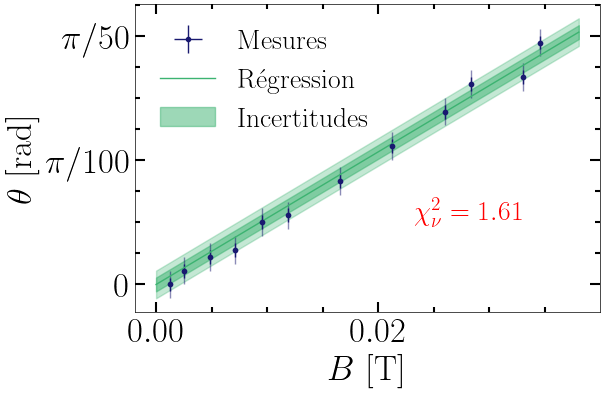

In [19]:
B_fit_1 = np.linspace(0, 1.1 * x.max(), 500)
y_pred_fit_1 = linear_2(B_fit_1, params_fitted=param_fitted_1)

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

ax.errorbar(x, angle_1,  fmt = ".", label = "Mesures", yerr = std_angle_extension, xerr = std_B, color = "midnightblue")
ax.errorbar(x, angle_1, fmt = ".", label = "Mesures", yerr = 2 * std_angle_extension, xerr = 2 * std_B, color = "midnightblue", alpha = 0.5)

ax.plot(B_fit_1, y_pred_fit_1, label = "Régression", color = "mediumseagreen")


k = 1
ax.fill_between(
    x = B_fit_1,
    y1 = y_pred_fit_1 - k * std_angle_extension, 
    y2 = y_pred_fit_1 + k * std_angle_extension,
    color = "mediumseagreen", 
    label = "Incertitudes", 
    alpha = 0.5 
)

k = 2
ax.fill_between(
    x = B_fit_1,
    y1 = y_pred_fit_1 - k * std_angle_extension, 
    y2 = y_pred_fit_1 + k * std_angle_extension,
    color = "mediumseagreen", 
    alpha = 0.3 
)
ax.set(ylabel = r"$\theta$ [rad]", xlabel = r"$B$ [T]")
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2, xy = (0.6, 0.3), xycoords = "axes fraction", color = "red", fontsize = 20)
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.set_yticks([0, np.pi/100, np.pi/50])
ax.set_yticklabels([r"0", r"$\pi/100$", r"$\pi/50$"])
ax.legend(loc = "upper left", handles = [handles[idx] for idx in order], labels = [labels[idx] for idx in order])
plt.savefig(figure_folder + "method_extension.pdf", bbox_inches = "tight")

Créons une fonction englobant tout ça

In [354]:
def plot_verdet(fig, ax, B_data, angle_data, std_B, std_angle, param_reg, color_reg = "mediumseagreen", color_data = "midnightblue", shift_angle = 0, labels = True):
    if labels: 
        label_reg = "Régression"
        label_data = "Mesures"
        label_uncertainty = "Incertitudes"
    else: 
        label_reg = None
        label_data = None
        label_uncertainty = None
    B_fit = np.linspace(0, 1.1 * B_data.max(), 500)
    y_pred_fit = linear_2(B_fit, params_fitted=param_reg) + shift_angle
    ax.errorbar(B_data, angle_data + shift_angle,  fmt = ".", label = label_data, yerr = std_angle, xerr = std_B, color = color_data)
    ax.errorbar(B_data, angle_data+ shift_angle, fmt = ".", label = label_data, yerr = 3 * std_angle, xerr = 3 * std_B, color = color_data, alpha = 0.3)

    ax.plot(B_fit, y_pred_fit, label = label_reg, color = color_data)

    k = 1
    ax.fill_between(
        x = B_fit,
        y1 = y_pred_fit - k * std_angle, 
        y2 = y_pred_fit + k * std_angle,
        color = color_reg, 
        label = label_uncertainty, 
        alpha = 0.5 
    )

    k = 3
    ax.fill_between(
        x = B_fit,
        y1 = y_pred_fit - k * std_angle, 
        y2 = y_pred_fit + k * std_angle,
        color = color_reg, 
        alpha = 0.3 
    )
    ax.set(ylabel = r"$\theta$ [rad]", xlabel = r"$B$ [T]")


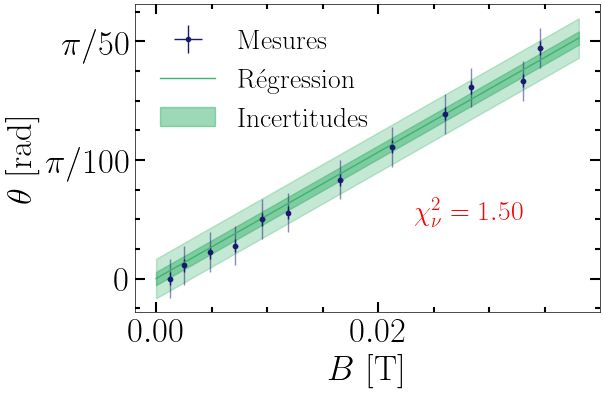

In [64]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

plot_verdet(
    fig = fig, 
    ax = ax, 
    B_data = B_1-B0, 
    angle_data = angle_1, 
    std_B = std_B, 
    std_angle = std_angle_extension, 
    param_reg = param_fitted_1
)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2, xy = (0.6, 0.3), xycoords = "axes fraction", color = "red", fontsize = 20)
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.set_yticks([0, np.pi/100, np.pi/50])
ax.set_yticklabels([r"0", r"$\pi/100$", r"$\pi/50$"])
ax.legend(loc = "upper left", handles = [handles[idx] for idx in order], labels = [labels[idx] for idx in order])



De notre analyse précédente, le paramètre que l'on a ajusté vaut 
$$
\alpha = VL
$$
On obtient V simplement en divisant par la longueur de l'échantillon. 

In [22]:
V = params_fitted / L 
std_V = std_fitted / L
print(f"{V.item():.2f}+/-{std_V.item():.2f} rad/T.m")

16.75+/-0.25 rad/T.m


#### Méthode 2: Extension (45 degrés)

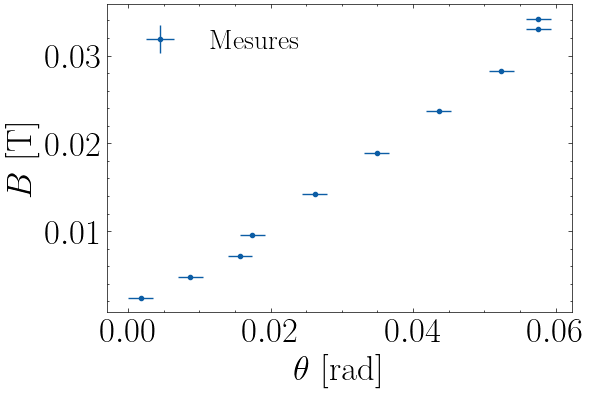

In [175]:
# Importer les données (d = 9 cm, i.e. au milieu de la bobine)
data = np.loadtxt(data_folder + "method_45.txt", skiprows=1)
theta0 = (168-45) * u.degree.to(u.radian) 
angle_2 = data[:, 0] * u.degree.to(u.radian) - theta0  # radians
# std_angle = 0.1 * u.degree.to(u.radian)
L = 10 * 1e-2 # meters
Ib = data[:, 1]  # courant dans la bobine (A)
B_2 = Ib_to_B(Ib)

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.errorbar(angle_2, B_2-B0, fmt = ".", label = "Mesures", xerr = std_angle_extension, yerr = std_B)
ax.set(xlabel = r"$\theta$ [rad]", ylabel = r"$B$ [T]")
ax.legend()

In [176]:
def linear_2(x, params_fitted):
    return params_fitted * x

x = B_2-B0
y = angle_2 # on échange puisque l'incertitude due à l'angle est plus importante ici
sigma_y = std_angle_extension

Regression_extension= FrequentistRegression(
    degree = 1,
    sigma_noise = sigma_y
)

param_fitted_2, std_fitted = Regression_extension.fit(
    obs = y, 
    x = x,
    ridge_reg = 1e-12,
    fit_intercept = False
)

y_pred = Regression_extension.forward_model()
cov = Regression_extension.cov
chi2_2 = Regression_extension.compute_chi2(obs = y)

print("The parameters fitted are", params_fitted)
print("The std of the params fitted are", std_fitted)
print("The cov of the params fitted is", cov)
print("The chi squared is:", chi2_2)


The parameters fitted are [-0.00285108  0.01172972]
The std of the params fitted are [0.02646903]
The cov of the params fitted is [[0.00070061]]
The chi squared is: 1.303502517009683


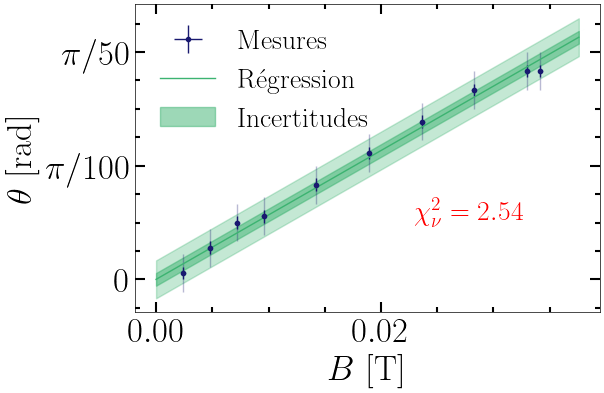

In [177]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

plot_verdet(
    fig = fig, 
    ax = ax, 
    B_data = B_2-B0, 
    angle_data = angle_2, 
    std_B = std_B, 
    std_angle = std_angle_extension, 
    param_reg = param_fitted_2
)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2, xy = (0.6, 0.3), xycoords = "axes fraction", color = "red", fontsize = 20)
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.set_yticks([0, np.pi/100, np.pi/50])
ax.set_yticklabels([r"0", r"$\pi/100$", r"$\pi/50$"])
ax.legend(loc = "upper left", handles = [handles[idx] for idx in order], labels = [labels[idx] for idx in order])



In [179]:
V2 = param_fitted_2 / L 
std_V2 = std_fitted / L
print(f"{V2.item():.2f}+/-{std_V2.item():.2f} rad/T.m")

17.80+/-0.26 rad/T.m


##### Méthode 3: Loi de Malus
D'après la dérivation faite dans le syllabus, la différence entre le cas avec champ magnétique et sans champ magnétique est donnée par
$$
\Delta I_1 = I_1(0)\sin(2\theta)
$$

On peut isoler $\theta$ comme 
$$
\theta = \frac{1}{2}\arcsin\left(\frac{\Delta I_1}{I_1(0)}\right)
$$

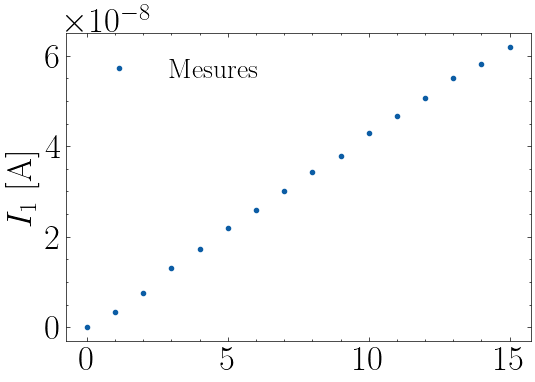

In [381]:
# Importer les données (d = 9 cm, i.e. au milieu de la bobine)
data = np.loadtxt(data_folder + "method_malus.txt", skiprows=1)
B_3 = (Ib_to_B(data[:,0]))
I1 = data[:, 1] * 1e-6 # amperes
I1_0 = I1[0]
delta_I = I1 - I1_0
std_I1 = 0.5e-6
angle_3 = 0.5 * np.arcsin(delta_I / I1_0)
std_delta_I = std_I1 * np.sqrt(2) 
std_angle_malus = 0.0005
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.plot(delta_I, ".", label = "Mesures")
ax.set(ylabel = r"$I_1$ [A]")
ax.legend()

In [365]:
def propagate_uncertainty_malus(delta_I, I0, std_deltaI, std_I0):
    a = std_deltaI ** 2 / np.abs(I0 ** 2 - delta_I ** 2)
    print(1/(np.abs(I0 ** 2 - delta_I ** 2)))
    b = std_I0 ** 2  * (delta_I ** 2 / I0 ** 2) * 1 / np.abs(I0 ** 2 - delta_I ** 2)
    return 0.5 * np.sqrt(a + b)

In [348]:
def linear_2(x, params_fitted):
    return params_fitted * x

x = B_3-B0
y = angle_3 # on échange puisque l'incertitude due à l'angle est plus importante ici
sigma_y = std_angle_malus

Regression_extension= FrequentistRegression(
    degree = 1,
    sigma_noise = sigma_y
)

param_fitted_3, std_fitted = Regression_extension.fit(
    obs = y, 
    x = x,
    ridge_reg = 1e-12,
    fit_intercept = False
)

y_pred = Regression_extension.forward_model()
cov = Regression_extension.cov
chi2_3 = Regression_extension.compute_chi2(obs = y)

print("The parameters fitted are", params_fitted)
print("The std of the params fitted are", std_fitted)
print("The cov of the params fitted is", cov)
print("The chi squared is:", chi2)


The parameters fitted are [-0.00285108  0.01172972]
The std of the params fitted are [0.00602318]
The cov of the params fitted is [[3.62786923e-05]]
The chi squared is: 2.5382542559590764


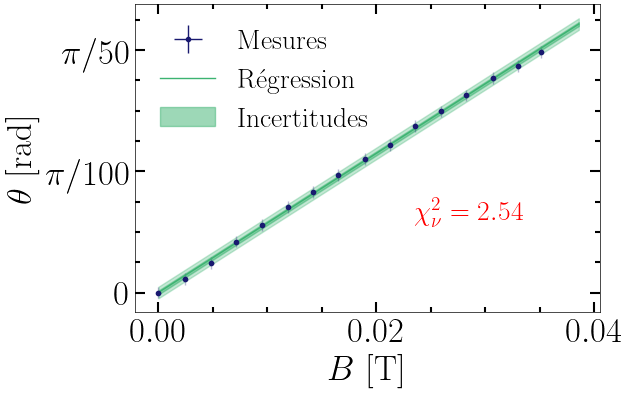

In [349]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

plot_verdet(
    fig = fig, 
    ax = ax, 
    B_data = B_3-B0, 
    angle_data = angle_3, 
    std_B = std_B, 
    std_angle = std_angle_malus, 
    param_reg = param_fitted_3
)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2, xy = (0.6, 0.3), xycoords = "axes fraction", color = "red", fontsize = 20)
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.set_yticks([0, np.pi/100, np.pi/50])
ax.set_yticklabels([r"0", r"$\pi/100$", r"$\pi/50$"])
ax.legend(loc = "upper left", handles = [handles[idx] for idx in order], labels = [labels[idx] for idx in order])



In [350]:
V3 = param_fitted_3 / L 
std_V = std_fitted / L
print(f"{V3.item():.2f}+/-{std_V.item():.2f} rad/T.m")

18.03+/-0.06 rad/T.m


Mettons toutes les données + régression du mode courant continu ensemble

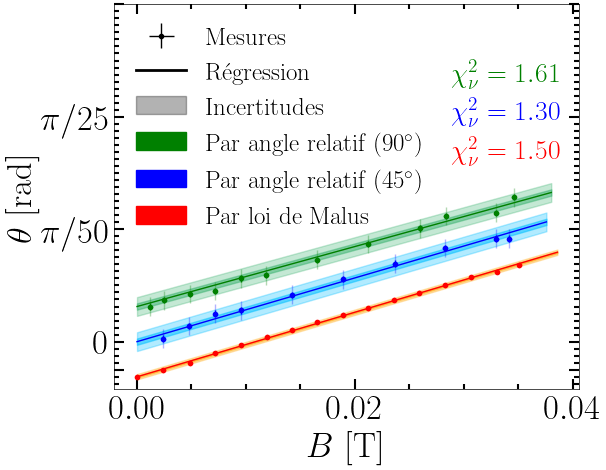

In [355]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))

shift = np.pi/200 * 1.25
plot_verdet(
    fig = fig, 
    ax = ax, 
    B_data = B_1-B0, 
    angle_data = angle_1, 
    std_B = std_B, 
    std_angle = std_angle_extension, 
    param_reg = param_fitted_1,
    shift_angle = shift,
    color_data = "green",
    color_reg="mediumseagreen",
    labels = False
)
plot_verdet(
    fig = fig, 
    ax = ax, 
    B_data = B_2-B0, 
    angle_data = angle_2, 
    std_B = std_B, 
    std_angle = std_angle_extension, 
    param_reg = param_fitted_2,
    shift_angle = 0,
    color_data = "blue",
    color_reg="deepskyblue",
    labels = False
)

plot_verdet(
    fig = fig, 
    ax = ax, 
    B_data = B_3-B0, 
    angle_data = angle_3, 
    std_B = std_B, 
    std_angle = std_angle_malus, 
    param_reg = param_fitted_3,
    shift_angle = -shift,
    color_data = "red",
    color_reg="orange",
    labels = False
)

ax.errorbar([], [], fmt = ".", color = "k", label = "Mesures", xerr=std_B, yerr=std_angle_extension)
ax.plot([], [], color= "k", alpha = 1, label = "Régression", lw = 2)
ax.fill_between([], [], [], color= "k", alpha = 0.3, label = "Incertitudes")

fontsize = 20
ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2_1, xy = (0.725, 0.8), xycoords = "axes fraction", color = "green", fontsize = fontsize)
ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2_2, xy = (0.725, 0.7), xycoords = "axes fraction", color = "blue", fontsize = fontsize)
ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2_3, xy = (0.725, 0.6), xycoords = "axes fraction", color = "red", fontsize = fontsize)
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.fill_between([], [], [], color= "green", alpha = 1, label = r"Par angle relatif (90$^\circ$)")
ax.fill_between([], [], [], color= "blue", alpha = 1, label = r"Par angle relatif (45$^\circ$)")
ax.fill_between([], [], [], color= "red", alpha = 1, label = "Par loi de Malus")
ax.set_yticks([-np.pi/200, 0, np.pi/50, np.pi/25, 3 * np.pi/50])
ax.set_yticklabels(["", r"0", r"$\pi/50$", r"$\pi/25$", ""])
handles, labels = plt.gca().get_legend_handles_labels()
order = [5,0, 1, 2, 3, 4]

# ax.set_ylim([-np.pi/100, 4* np.pi/100])
ax.set_ylabel(r"$\theta$ [rad]", labelpad=0)
ax.legend(loc = "upper left", handles = [handles[idx] for idx in order], labels = [labels[idx] for idx in order], fontsize = fontsize-2)
plt.savefig(figure_folder + "methods_DC.pdf")

In [116]:
V=params_fitted/L
print(V)

[18.03082327]


### Semaine 2: 
Deux parties. 
1) Mesure de la constante de Verdet en courant alternatif avec un ADS. 
2) Mesure de la constante de Verdet pour différentes longueurs d'onde. 

In [308]:
def propagate_uncertainty_malus(delta_I, I0, std_deltaI, std_I0):
    a = std_deltaI ** 2 / np.abs(I0 ** 2 - delta_I ** 2)
    b = std_I0 ** 2  * (delta_I ** 2 / I0 ** 2) * 1 / np.abs(I0 ** 2 - delta_I ** 2)
    return 0.5 * np.sqrt(a + b)

In [323]:
B_ads-B0

array([0.01172972, 0.00692054, 0.00668594, 0.0041054 , 0.00375351,
       0.00281513, 0.00258054, 0.00187676, 0.00152486, 0.00093838,
       0.00082108, 0.00070378])

In [322]:
std_B

np.float64(7.218032973047506e-05)

[6.93689864e+10 6.92944796e+10 6.92859336e+10 6.92682146e+10
 6.92622271e+10 6.92605385e+10 6.92563941e+10 6.92539960e+10
 6.92530176e+10 6.92525572e+10 6.92523845e+10 6.92522502e+10]


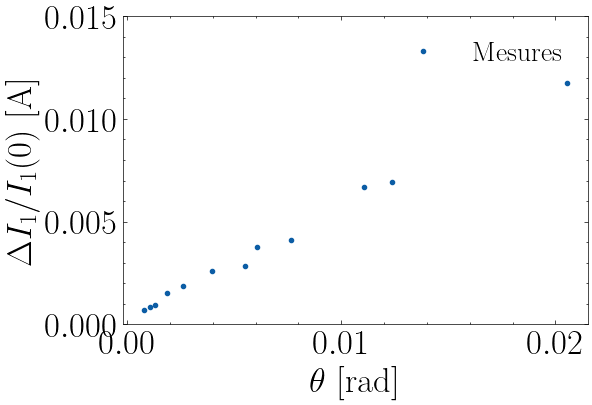

In [580]:
data = np.loadtxt(data_folder + "method_ADS_laser.txt", skiprows=1)
B_ads = (Ib_to_B(data[:,0]))
I1_0 = 3.8 * 1e-6 # A
delta_I = data[:, 1] * 2 * 1e-7 # A 
std_delta_I = 0.03e-7
std_I1_0 = 0.05e-6
angle_ads = 0.5 * np.arcsin(delta_I / I1_0)
std_angle_ads =  propagate_uncertainty_malus(delta_I, I1_0, std_delta_I, std_I1_0).mean() # to compute  
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.plot(angle_ads, B_ads-B0, ".", label = "Mesures")
ax.set(ylabel = r"$\Delta I_1/I_1(0)$ [A]" ,xlabel = r"$\theta$ [rad]", ylim = [0, 0.015])
ax.legend()

In [581]:
std_angle = propagate_uncertainty_malus(delta_I, I1_0, std_delta_I, std_I1_0).mean()
print(angle_ads)
print(std_angle)

[6.93689864e+10 6.92944796e+10 6.92859336e+10 6.92682146e+10
 6.92622271e+10 6.92605385e+10 6.92563941e+10 6.92539960e+10
 6.92530176e+10 6.92525572e+10 6.92523845e+10 6.92522502e+10]
[0.02053209 0.01236968 0.01105353 0.00763188 0.00605278 0.00552643
 0.00394741 0.00263159 0.00184211 0.00131579 0.00105263 0.00078947]
0.0004094095883698142


Propagation des incertitudes 

In [582]:
def linear_2(x, params_fitted):
    return params_fitted * x

x = B_ads-B0
y = angle_ads # on échange puisque l'incertitude due à l'angle est plus importante ici
sigma_y = std_angle_ads 

Regression_extension = FrequentistRegression(
    degree = 1,
    sigma_noise = sigma_y
)

param_fitted_ads, std_fitted = Regression_extension.fit(
    obs = y, 
    x = x,
    ridge_reg = 1e-12,
    fit_intercept = False
)

y_pred = Regression_extension.forward_model()
cov = Regression_extension.cov
chi2_ads = Regression_extension.compute_chi2(obs = y)

print("The parameters fitted are", param_fitted_ads)
print("The std of the params fitted are", std_fitted)
print("The cov of the params fitted is", cov)
print("The chi squared is:", chi2_ads)

The parameters fitted are [1.729653]
The std of the params fitted are [0.02431082]
The cov of the params fitted is [[0.00059102]]
The chi squared is: 1.6683829000394645


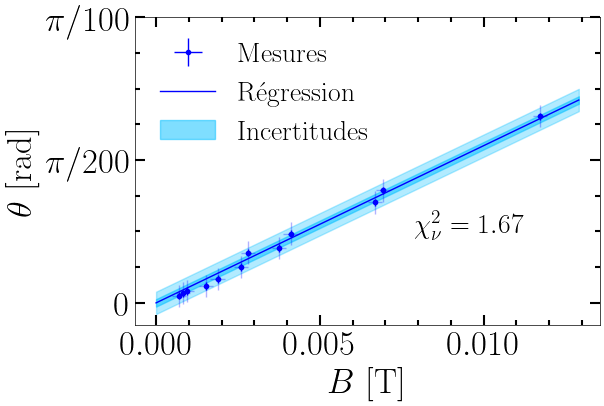

In [583]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

plot_verdet(
    fig = fig, 
    ax = ax, 
    B_data = B_ads-B0, 
    angle_data = angle_ads, 
    std_B = std_B, 
    std_angle = std_angle_ads, 
    param_reg = param_fitted_ads,
    color_data="blue",
    color_reg = "deepskyblue"
)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2_ads, xy = (0.6, 0.3), xycoords = "axes fraction", color = "k", fontsize = 20)
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.set_yticks([0, np.pi/200, np.pi/100])
ax.set_yticklabels([r"0", r"$\pi/200$", r"$\pi/100$"])
ax.legend(loc = "upper left", handles = [handles[idx] for idx in order], labels = [labels[idx] for idx in order])
plt.savefig(figure_folder + "method_ADS.pdf", bbox_inches = "tight")

In [329]:
V = param_fitted_ads / L
std_V = std_fitted
print(f"{V.item():.3f} +/- {std_V.item():.3f}")

17.297 +/- 0.017


##### Dépendance de la constante de Verdet en fonction de la longueur d'onde

La proportionnalité de la constante de Verdet au facteur $\lambda \frac{dn}{d \lambda}$ implique une dépendance
$$
V(\lambda) \propto \lambda^{-2}
$$\
pour le SF57 puisque $n(\lambda)\propto \lambda^{-2}$. 

Commençons par créer une fonction qui va calculer la constante de Verdet pour nous rapidement. 

In [398]:
# Importer les données (d = 9 cm, i.e. au milieu de la bobine)
def compute_verdet_malus(filename):
    data = np.loadtxt(filename, skiprows=1)
    B_3 = (Ib_to_B(data[:,0]))
    I1 = data[:, 1] * 1e-6 # amperes
    I1_0 = I1[0]
    delta_I = np.abs(I1 - I1_0)
    std_I1 = 0.5e-6
    angle_3 = 0.5 * np.arcsin(delta_I / I1_0)
    std_delta_I = std_I1 * np.sqrt(2) 
    std_angle_malus = 0.0005
    # fig, ax = plt.subplots(1, 1, figsize = (6, 4))
    # ax.plot(delta_I, ".", label = "Mesures")
    # ax.set(ylabel = r"$I_1$ [A]")
    # ax.legend()

    x = B_3-B0
    y = angle_3 # on échange puisque l'incertitude due à l'angle est plus importante ici
    sigma_y = std_angle_malus

    Regression_extension= FrequentistRegression(
        degree = 1,
        sigma_noise = sigma_y
    )

    param_fitted_3, std_fitted = Regression_extension.fit(
        obs = y, 
        x = x,
        ridge_reg = 1e-12,
        fit_intercept = False
    )

    y_pred = Regression_extension.forward_model()
    cov = Regression_extension.cov
    chi2_3 = Regression_extension.compute_chi2(obs = y)

    print("The parameters fitted are", params_fitted)
    print("The std of the params fitted are", std_fitted)
    print("The cov of the params fitted is", cov)
    print("The chi squared is:", chi2)

    fig, ax = plt.subplots(1, 1, figsize = (6, 4))

    plot_verdet(
        fig = fig, 
        ax = ax, 
        B_data = B_3-B0, 
        angle_data = angle_3, 
        std_B = std_B, 
        std_angle = std_angle_malus, 
        param_reg = param_fitted_3,
        color_data="blue",
        color_reg = "deepskyblue"
    )
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,0,1]
    ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2, xy = (0.6, 0.3), xycoords = "axes fraction", color = "red", fontsize = 20)
    ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
    ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
    ax.set_yticks([0, np.pi/100, np.pi/50])
    ax.set_yticklabels([r"0", r"$\pi/100$", r"$\pi/50$"])
    ax.legend(loc = "upper left", handles = [handles[idx] for idx in order], labels = [labels[idx] for idx in order])

    V3 = param_fitted_3 / L 
    std_L = 0.5e-2 # metres
    std_V = np.sqrt(std_fitted ** 2 + param_fitted_3 ** 2/ L **2 * std_L**2) / L
    print(f"{V3.item():.2f}+/-{std_V.item():.2f} rad/T.m")

    return (V3, std_V)

The parameters fitted are [-0.00285108  0.01172972]
The std of the params fitted are [0.00602318]
The cov of the params fitted is [[3.62786923e-05]]
The chi squared is: 2.5382542559590764
18.03+/-0.90 rad/T.m


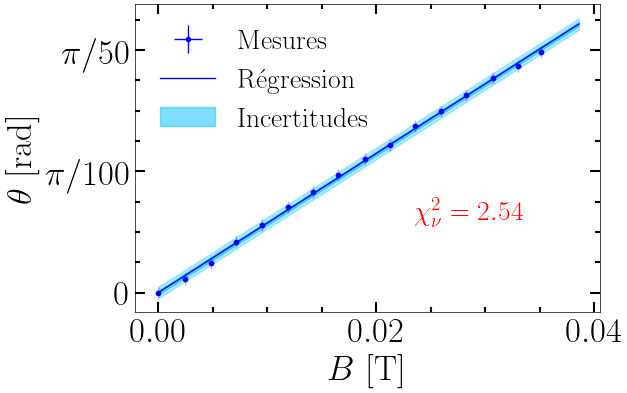

In [399]:
filename = data_folder + "method_malus.txt"
V, std_V = compute_verdet_malus(filename)

In [391]:
from glob import glob
import os 



['C:/Users/noedi/Desktop/lab_optique/data/faraday/data\\method_malus_green.txt',
 'C:/Users/noedi/Desktop/lab_optique/data/faraday/data\\method_malus_jaune.txt',
 'C:/Users/noedi/Desktop/lab_optique/data/faraday/data\\method_malus_purple.txt',
 'C:/Users/noedi/Desktop/lab_optique/data/faraday/data\\method_malus_rouge.txt']

In [397]:
os.path.basename(paths[0]).replace(".", "_").split("_")[-2]

'green'

The parameters fitted are [-24.7873718   -1.94795397]
The std of the params fitted are [0.01147873]
The cov of the params fitted is [[0.00013176]]
The chi squared is: 0.035793085343525016
22.48+/-1.13 rad/T.m


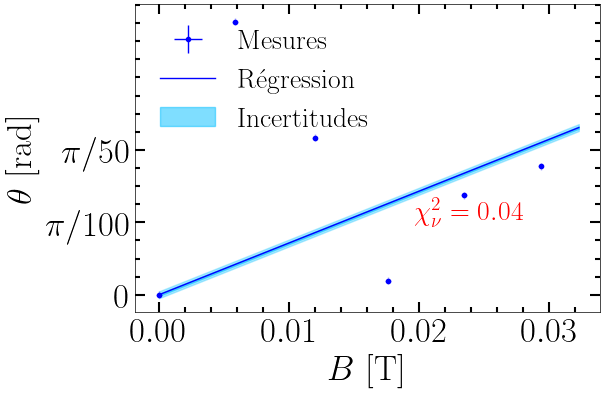

In [443]:
V_color, std_V_color = compute_verdet_malus(paths[1])


The parameters fitted are [-24.7873718   -1.94795397]
The std of the params fitted are [0.01145789]
The cov of the params fitted is [[0.00013128]]
The chi squared is: 0.035793085343525016
27.25+/-1.37 rad/T.m
The parameters fitted are [-24.7873718   -1.94795397]
The std of the params fitted are [0.01147873]
The cov of the params fitted is [[0.00013176]]
The chi squared is: 0.035793085343525016
22.48+/-1.13 rad/T.m
The parameters fitted are [-24.7873718   -1.94795397]
The std of the params fitted are [0.01146635]
The cov of the params fitted is [[0.00013148]]
The chi squared is: 0.035793085343525016
37.21+/-1.86 rad/T.m
The parameters fitted are [-24.7873718   -1.94795397]
The std of the params fitted are [0.01145789]
The cov of the params fitted is [[0.00013128]]
The chi squared is: 0.035793085343525016
16.43+/-0.83 rad/T.m


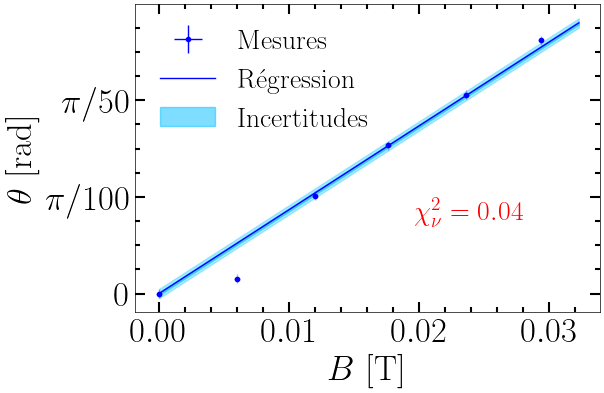

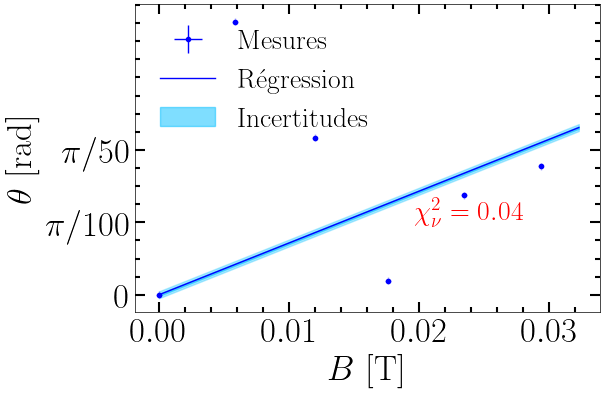

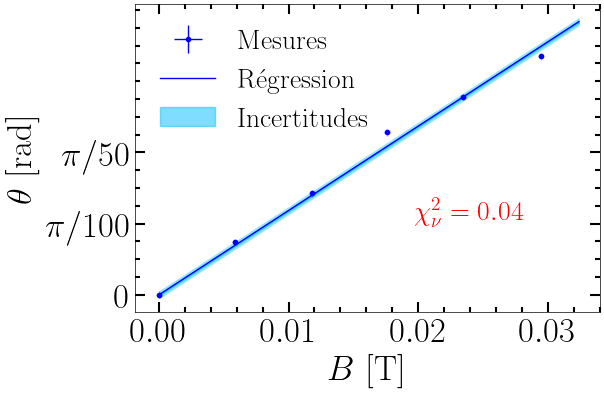

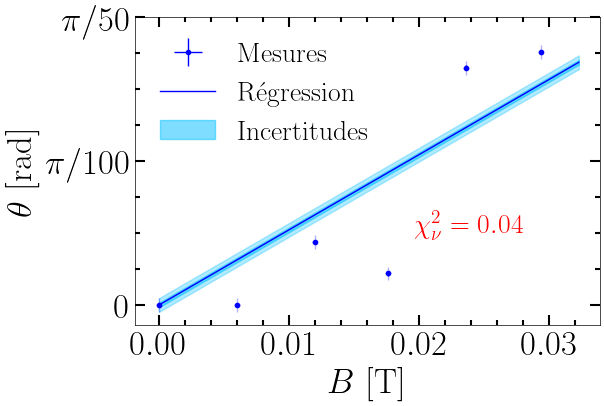

In [444]:
paths = glob(data_folder + "method_malus_*.txt")
V = []
std_V = []
colors = []
for path in paths: 
    color = os.path.basename(path).replace(".", "_").split("_")[-2]
    V_color, std_V_color = compute_verdet_malus(path)
    V.append(V_color.item())
    std_V.append(std_V_color.item())
    colors.append(color)

V = np.array(V)
std_V = np.array(std_V)

[]

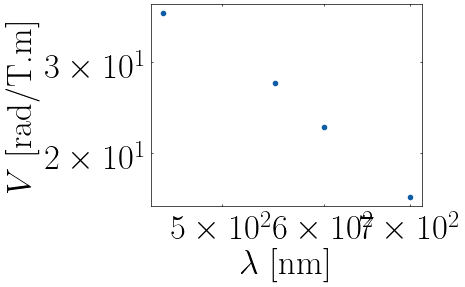

In [445]:
wavelength = np.array([550, 600, 450, 700]) * 1e-9
plt.plot(wavelength * 1e9, V, ".")
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel(r"$V$ [rad/T.m]")
plt.loglog()

On souhaite faire l'ajustement en espace logarithmique et, surtout, on veut prouver la dépendance en $\lambda^{-2}$. On a  
$$
\begin{align}
\ln(V)&= \ln(\lambda^{a}) + \ln(C)
\\
&= a\ln(\lambda) + \ln(C)
\end{align}
$$
où $C$ est une constante. Si à l'issue de notre ajustement, on obtient $a=-2$, c'est win. 

In [446]:
std_V

array([1.36735577, 1.12984571, 1.86422584, 0.82958959])

In [509]:
obs = np.log(V)
x = np.log(wavelength)
sigma_noise = std_V/40
Regression_wave = FrequentistRegression(
    degree = 1,
    sigma_noise = sigma_noise
) 

params_fitted, std_fitted = Regression_wave.wfit(
    obs = obs, 
    x = x, 
    ridge_reg = 1e-12, 
    fit_intercept = True
)
chi2 = Regression_wave.compute_chi2(obs = obs)
y_pred = Regression_wave.forward_model()
print("Chi carré:", chi2)
print("Fitted parameters:", params_fitted)
print("Uncertainty on fitted parameters:", std_fitted)
print("Covariance", Regression_wave.cov) # A bit of correlation here... Let's ignore it ! 

[ 855.7697372  1253.37695107  460.38687809 2324.84177145]
(4, 4)
Chi carré: 0.9919865401905946
Fitted parameters: [-24.47104728  -1.92480934]
Uncertainty on fitted parameters: [1.45980195 0.10211213]
Covariance [[2.13102174 0.14905639]
 [0.14905639 0.01042689]]


In [507]:
std_V/40

array([0.03418389, 0.02824614, 0.04660565, 0.02073974])

In [480]:
def exp_law(wavelength, params_fitted): 
    a, b = params_fitted
    print(a, b)
    return np.exp(a) * wavelength ** b

-24.47104727703092 -1.9248093360453247


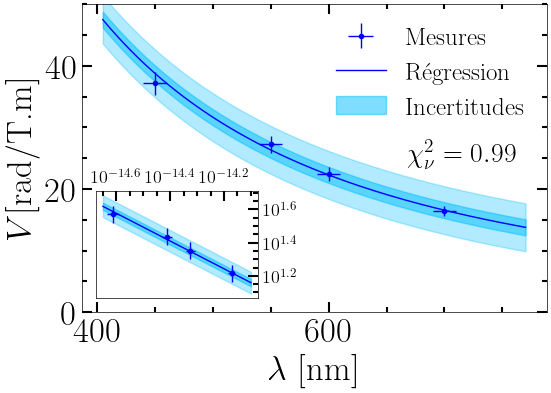

In [577]:
std_wavelength = 10e-9
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
wavelength_fit = np.linspace(wavelength.min()*0.9, wavelength.max()*1.1, 500)
y_pred_fit = exp_law(wavelength_fit, params_fitted = params_fitted)

ax.errorbar(wavelength*1e9, V, fmt = ".", xerr = std_wavelength * 1e9, yerr=std_V, color = "blue", label = "Mesures")
ax.plot(wavelength_fit*1e9, y_pred_fit, color = "blue", label = "Régression")

k = 1
ax.fill_between(
    x = wavelength_fit*1e9, 
    y1 = y_pred_fit - k * std_V.mean(), 
    y2 = y_pred_fit + k * std_V.mean(),
    color = "deepskyblue", 
    label = "Incertitudes",
    alpha = 0.5
)

k = 3
ax.fill_between(
    x = wavelength_fit*1e9, 
    y1 = y_pred_fit - k * std_V.mean(), 
    y2 = y_pred_fit + k * std_V.mean(),
    color = "deepskyblue", 
    alpha = 0.3
)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 0,1]

# ax.set_ylim([-np.pi/100, 4* np.pi/100])
ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2, xy = (0.7, 0.49), xycoords = "axes fraction", color = "k", fontsize = 20)
ax.set(xlabel = r"$\lambda$ [nm]", ylabel = r"$V$[rad/T.m]", ylim = [0, 50])
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.legend(loc = "upper right", handles = [handles[idx] for idx in order], labels = [labels[idx] for idx in order], fontsize = fontsize-2)


from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Create inset axes inside `ax`
inset_ax = inset_axes(ax, width="35%", height="35%", loc="lower left")  # Adjust size and position as needed
inset_ax.errorbar(x, np.log10(V), fmt = ".", xerr = np.abs(std_wavelength / wavelength), yerr = std_V/V, color = "blue", label = "Mesures")

x_fit = np.linspace(-14.65, -14.1)
y_fit_linear = params_fitted[0] + params_fitted[1] * x_fit
inset_ax.plot(x_fit, y_fit_linear/np.log(10), label = "Régression", color = "blue")

k = 1
inset_ax.fill_between(
    x = x_fit, 
    y1 = (y_fit_linear - k * (std_V/V).mean())/np.log(10), 
    y2 = (y_fit_linear + k * (std_V/V).mean())/np.log(10),
    color = "deepskyblue", 
    label = "Incertitudes",
    alpha = 0.5
)

k = 3
inset_ax.fill_between(
    x = x_fit, 
    y1 = (y_fit_linear - k * (std_V/V).mean())/np.log(10), 
    y2 = (y_fit_linear + k * (std_V/V).mean())/np.log(10),
    color = "deepskyblue", 
    alpha = 0.3
)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 0,1]

# inset_ax.set_ylim([-np.pi/100, 4* np.pi/100])
# inset_ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2, xy = (0.7, 0.45), xycoords = "axes fraction", color = "k", fontsize = 20)
# inset_ax.set(xlabel = r"$\lambda$ [nm]", ylabel = r"$V$[rad/T.m]")
inset_ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
inset_ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
# inset_ax.tick_params(which = 'both', axis = 'x', direction = "out")
inset_ax.set_xticks([-14.6, -14.4, -14.2])
inset_ax.set_xticklabels([r"$10^{-14.6}$", r"$10^{-14.4}$", r"$10^{-14.2}$"], fontsize = 13)
inset_ax.set_yticks([1.2, 1.4, 1.6])
# inset_ax.xaxis.set_ticklabels_position("top")
inset_ax.xaxis.tick_top()  # Move the x-axis label to the top
inset_ax.yaxis.tick_right()
inset_ax.set_yticklabels([r"$10^{1.2}$", r"$10^{1.4}$", r"$10^{1.6}$"], fontsize = 13)
# inset_ax.legend(loc = "upper right", handles = [handles[idx] for idx in order], labels = [labels[idx] for idx in order], fontsize = fontsize-2)
plt.savefig(figure_folder + "verdet_vs_wavelength.pdf", bbox_inches = "tight")

In [19]:
std_V/V

NameError: name 'std_V' is not defined

### Bonus 2: The Bayesian way
Essayons d'inférer la constante de Verdet avec les quatre méthodes pour une discussion plus facile. On souhaite ici échantilloner une distribution a posteriori définie par la relation 
$$
p(V|\theta, B, L) \propto p(\theta, B, L|V) p(V) \, .
$$

Posons notre observation $\mathbf{y}=(\boldsymbol{\theta}, B, L)$. Le _score_ du posterior est défini comme 
$$
\nabla_V \log p(V|\mathbf{y})= \nabla_V \log p(\mathbf{y}\mid V) + \nabla_V \log p(V)
$$
Cette quantité nous permet d'inférer $V$ avec une méthode numérique, soit un algorithme appelé MALA. 

Définissons maintenant la vraisemblance. On assume un bruit Gaussien dans notre cas, En assumant une dimensionnalité $d$ de $\mathbf{y}$, on a 
$$
p(\mathbf{y}\mid V)=C \times \exp\left[\sum_{i}-\frac{1}{2\sigma_{i}^2} (y_i-VB_iL)^2\right]
$$

In [1]:
!pip install pymc

  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Prep


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install scikit-learn

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ------------------------- -------------- 7.1/11.0 MB 43.7 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 38.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
